# Homework 6

## The Momentum Product

Q1) AQR's momentum product introduces several novel aspects compared to existing momentum investment products:

Retail Accessibility: Unlike most momentum strategies traditionally available only to institutional investors or via hedge funds, AQR's product is one of the first to target retail investors, making it accessible to a broader audience.

Long-Only Focus: The product is designed as a long-only fund, which differentiates it from many existing products that include both long and short positions. This design aligns with mutual fund regulations and broadens its appeal to investors who may have constraints against short-selling.

Adapted Indexes: AQR developed specific long-only momentum indexes tailored for different market caps and international markets, using a transparent methodology that selects stocks based on performance over the previous 11 months, excluding the most recent month to avoid short-term reversal effects.

2)Market Impact and Transaction Costs: The actual costs of trading (transaction fees, bid-ask spread, market impact of trades) can differ from those assumed in backtests or those inherent in the index methodology, especially in a mutual fund format with daily liquidity requirements.

3)Avoidance of Short-Term Reversal: stocks that perform extremely well or poorly in the most recent month tend to reverse those performances in the following month. By excluding the most recent month, AQR aims to mitigate the impact of these short-term reversals on the momentum strategy’s performance.

# Question 2: Investigating Momentum

### Q2.1 Is Momentum still profitable

In [1]:
# try again
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns   
from sklearn.linear_model import LinearRegression
import os
import sys
from typing import Union
from functools import reduce
notebook = "practice"
if notebook in os.getcwd():
    os.chdir(os.pardir)
    print(os.getcwd())

c:\Users\Andik\OneDrive\Desktop\Chicago\Portfolio theory and risk management\githubrepo\finm-portfolio-2024


In [2]:
# data
momentum_ff_data = pd.read_excel("./data/momentum_data.xlsx", sheet_name = 2, parse_dates = True, index_col = 0)
factor_data = pd.read_excel("./data/momentum_data.xlsx", sheet_name = 1, parse_dates = True, index_col = 0)
def calc_stats(data, market = factor_data["MKT"], value = factor_data["HML"] ,annual_factor = 12, quantile = 0.05):
    if isinstance(data, pd.Series):
        data = data.to_frame()
    stats_df = pd.DataFrame()
    stats_df["Mean"]  = data.mean()
    stats_df["Std"] = data.std()
    stats_df["Skew"] = data.skew()
    stats_df["Kurt"] = data.kurt()
    stats_df["Annualsied_mean"] = stats_df["Mean"] * annual_factor
    stats_df["Annualsied_std"] = stats_df["Std"] * np.sqrt(annual_factor)
    stats_df["Sharpe"] = stats_df["Mean"] / stats_df["Std"]
    stats_df["Annualsied_Sharpe"] = stats_df["Sharpe"] * np.sqrt(annual_factor)
    stats_df["VaR"] = data.quantile(quantile)
    stats_df["CVaR"] = data[data < data.quantile(quantile)].mean()
    stats_df["Max_Drawdown"] = data.apply(lambda x: (1+x).cumprod().div((1+x).cumprod().cummax()).sub(1).min())
    stats_df["Corr to market"] = data.corrwith(market.loc[data.first_valid_index():data.last_valid_index()])
    stats_df["Corr to value"] = data.corrwith(value.loc[data.first_valid_index():data.last_valid_index()])
    return stats_df
# calculate the stats
momentum_stats = calc_stats(momentum_ff_data)
display(momentum_stats.T)
# subsamples 
data = momentum_ff_data.copy()
subsamples_data = {"1927-2024": data.loc["1927":"2024"],
                   "1927-1993": data.loc["1927":"1993"],
                   "1994-2008": data.loc["1994":"2008"],
                   "2009-2024": data.loc["2009":"2024"],
                   "1994-2024": data.loc["1994":"2024"]}
subsamples_stats = {key: calc_stats(value).T for key, value in subsamples_data.items()}
subsamples_stats = pd.concat(subsamples_stats, axis = 1)
display(subsamples_stats.T)

,UMD
Mean,0.006277
Std,0.046912
Skew,-2.990493
Kurt,27.052405
Annualsied_mean,0.075328
Annualsied_std,0.162508
Sharpe,0.133811
Annualsied_Sharpe,0.463534
VaR,-0.062040
CVaR,-0.118015


,,Mean,Std,Skew,Kurt,Annualsied_mean,Annualsied_std,Sharpe,Annualsied_Sharpe,VaR,CVaR,Max_Drawdown,Corr to market,Corr to value
1927-2024,UMD,0.006277,0.046912,-2.990493,27.052405,0.075328,0.162508,0.133811,0.463534,-0.062040,-0.118015,-0.772352,-0.344284,-0.406410
1927-1993,UMD,0.007507,0.046189,-3.808207,36.924154,0.090081,0.160003,0.162522,0.562992,-0.055735,-0.112788,-0.772352,-0.362496,-0.495002
1994-2008,UMD,0.008698,0.050677,-0.582038,5.016890,0.104373,0.175551,0.171631,0.594548,-0.079245,-0.116922,-0.316793,-0.234519,-0.129361
2009-2024,UMD,-0.001258,0.045745,-2.691022,16.605929,-0.015092,0.158467,-0.027493,-0.095238,-0.070940,-0.127990,-0.562973,-0.367588,-0.320924
1994-2024,UMD,0.003599,0.048406,-1.445951,9.889308,0.043184,0.167682,0.074344,0.257534,-0.078400,-0.123079,-0.576366,-0.306180,-0.215225


In [3]:
# 1.2
## construct long only implementation of momentum
momentum_size_data = pd.read_excel("./data/momentum_data.xlsx", sheet_name = 4, parse_dates = True, index_col = 0)
momemtum_rf_data = pd.read_excel("./data/momentum_data.xlsx", sheet_name = 5, parse_dates = True, index_col = 0)
momentum_decile_data = pd.read_excel("./data/momentum_data.xlsx", sheet_name = 3, parse_dates = True, index_col = 0)
temp_data = pd.merge(momentum_size_data, momemtum_rf_data, left_index = True, right_index = True).merge(momentum_decile_data,left_index=True, right_index=True)
temp_data = temp_data.apply(lambda x: (x - temp_data["RF"]) if "RF" not in x else x, axis = 0)
temp_data = temp_data.drop(columns = "RF")
display(temp_data.head())
temp_data["long_only"] = 0.5 * (temp_data["BIG HiPRIOR"] + temp_data["SMALL HiPRIOR"]) 
temp_data["long_top_short_bottom"] = temp_data["Hi PRIOR"] -temp_data["Lo PRIOR"]
temp_data["long_top3_short_bottom3"] = 1/3 *(temp_data.loc[:,"PRIOR 8":"Hi PRIOR"].sum(axis=1)) - 1/3 * (temp_data.loc[:,"Lo PRIOR":"PRIOR 3"].sum(axis=1))
temp_data["long_top5_short_bottom5"] = 1/5 *(temp_data.loc[:,"PRIOR 6":"Hi PRIOR"].sum(axis=1)) - 1/5 * (temp_data.loc[:,"Lo PRIOR":"PRIOR 5"].sum(axis=1))
temp_data = temp_data.loc[:,["long_only","long_top_short_bottom","long_top3_short_bottom3","long_top5_short_bottom5"]]
display(temp_data.head())

,SMALL LoPRIOR,ME1 PRIOR2,SMALL HiPRIOR,BIG LoPRIOR,ME2 PRIOR2,BIG HiPRIOR,Lo PRIOR,PRIOR 2,PRIOR 3,PRIOR 4,PRIOR 5,PRIOR 6,PRIOR 7,PRIOR 8,PRIOR 9,Hi PRIOR
Date,,,,,,,,,,,,,,,,
1927-01-31,-0.0017,0.0332,0.0015,-0.0065,0.0001,-0.0025,-0.0357,-0.0471,0.0244,-0.0058,-0.0066,0.0072,0.0049,0.0011,-0.0066,-0.0049
1927-02-28,0.0675,0.0622,0.0525,0.0701,0.0354,0.0421,0.0727,0.0567,0.0799,0.0701,0.0296,0.0395,0.0257,0.0300,0.0394,0.0675
1927-03-31,-0.0376,-0.0318,-0.0236,-0.0387,-0.0048,0.0196,-0.0353,-0.0331,-0.0422,-0.0507,-0.0078,-0.0272,0.0175,0.0011,0.0066,0.0517
1927-04-30,-0.0100,-0.0073,0.0307,-0.0297,0.0050,0.0156,0.0179,-0.0345,-0.0272,-0.0162,0.0195,-0.0030,0.0180,-0.0084,0.0134,0.0524
1927-05-31,0.0218,0.1085,0.0653,0.0522,0.0466,0.0688,0.0242,0.0427,0.0565,0.0288,0.0606,0.0550,0.0466,0.0651,0.0781,0.0602


,long_only,long_top_short_bottom,long_top3_short_bottom3,long_top5_short_bottom5
Date,,,,
1927-01-31,-0.00050,0.0308,0.016000,0.01450
1927-02-28,0.04730,-0.0052,-0.024133,-0.02138
1927-03-31,-0.00200,0.0870,0.056667,0.04376
1927-04-30,0.02315,0.0345,0.033733,0.02258
1927-05-31,0.06705,0.0360,0.026667,0.01844


In [4]:
# subsamples 
data = temp_data.copy()
subsamples_data = {"1927-2024": data.loc["1927":"2024"],
                   "1927-1993": data.loc["1927":"1993"],
                   "1994-2008": data.loc["1994":"2008"],
                   "2009-2024": data.loc["2009":"2024"],
                   "1994-2024": data.loc["1994":"2024"]}
subsamples_stats = {key: calc_stats(value).T for key, value in subsamples_data.items()}
subsamples_stats = pd.concat(subsamples_stats, axis = 1)
display(subsamples_stats.T)

Mean       Std      Skew       Kurt  \
1927-2024 long_only                0.011282  0.061333 -0.015827   5.409196   
          long_top_short_bottom    0.011482  0.079091 -2.221209  15.678948   
          long_top3_short_bottom3  0.006307  0.054855 -2.511962  20.180907   
          long_top5_short_bottom5  0.004172  0.038549 -2.495177  20.232315   
1927-1993 long_only                0.011977  0.065370  0.068140   5.779820   
          long_top_short_bottom    0.013616  0.075501 -2.812613  23.637269   
          long_top3_short_bottom3  0.008110  0.054345 -3.101904  27.545870   
          long_top5_short_bottom5  0.005458  0.038444 -3.014291  27.003698   
1994-2008 long_only                0.007630  0.051765 -0.512167   1.594931   
          long_top_short_bottom    0.013883  0.081592 -0.854147   4.441902   
          long_top3_short_bottom3  0.007489  0.053330 -0.894938   4.640908   
          long_top5_short_bottom5  0.004714  0.037221 -1.140229   5.295308   
2009-2024 long_only                0.011801  0.051306 -0.382596   0.837732   
          long_top_short_bottom    0.000121  0.090306 -1.601342   5.431078   
          long_top3_short_bottom3 -0.002487  0.057823 -1.675280   7.834869   
          long_top5_short_bottom5 -0.001819  0.039856 -1.631718   7.837078   
1994-2024 long_only                0.009766  0.051503 -0.444802   1.188613   
          long_top_short_bottom    0.006834  0.086324 -1.304629   5.158568   
          long_top3_short_bottom3  0.002379  0.055825 -1.345002   6.580859   
          long_top5_short_bottom5  0.001368  0.038679 -1.415925   6.742942   

                                   Annualsied_mean  Annualsied_std    Sharpe  \
1927-2024 long_only                       0.135382        0.212464  0.183944   
          long_top_short_bottom           0.137789        0.273979  0.145180   
          long_top3_short_bottom3         0.075686        0.190025  0.114977   
          long_top5_short_bottom5         0.050059        0.133536  0.108215   
1927-1993 long_only                       0.143729        0.226449  0.183225   
          long_top_short_bottom           0.163390        0.261542  0.180340   
          long_top3_short_bottom3         0.097318        0.188256  0.149230   
          long_top5_short_bottom5         0.065501        0.133174  0.141984   
1994-2008 long_only                       0.091560        0.179320  0.147396   
          long_top_short_bottom           0.166593        0.282643  0.170149   
          long_top3_short_bottom3         0.089871        0.184740  0.140433   
          long_top5_short_bottom5         0.056563        0.128937  0.126637   
2009-2024 long_only                       0.141610        0.177728  0.230009   
          long_top_short_bottom           0.001454        0.312829  0.001342   
          long_top3_short_bottom3        -0.029850        0.200305 -0.043019   
          long_top5_short_bottom5        -0.021829        0.138067 -0.045640   
1994-2024 long_only                       0.117195        0.178410  0.189626   
          long_top_short_bottom           0.082010        0.299035  0.079169   
          long_top3_short_bottom3         0.028551        0.193383  0.042619   
          long_top5_short_bottom5         0.016411        0.133990  0.035357   

                                   Annualsied_Sharpe       VaR      CVaR  \
1927-2024 long_only                         0.637199 -0.088080 -0.135319   
          long_top_short_bottom             0.502920 -0.103740 -0.207051   
          long_top3_short_bottom3           0.398293 -0.075780 -0.140692   
          long_top5_short_bottom5           0.374869 -0.051044 -0.097751   
1927-1993 long_only                         0.634710 -0.094450 -0.144483   
          long_top_short_bottom             0.624717 -0.091745 -0.186493   
          long_top3_short_bottom3           0.516948 -0.069900 -0.136358   
          long_top5_short_bottom5           0.491848 -0.049160 -0.094277   
1994-2008 long_only                

In [5]:
# small portfolio
small_port = momentum_size_data["SMALL HiPRIOR"] - momentum_size_data["SMALL LoPRIOR"]
large_port = momentum_size_data["BIG HiPRIOR"] - momentum_size_data["BIG LoPRIOR"]
all_stocks = momentum_ff_data.copy()
[small_port, large_port, all_stocks] = [x.loc["1994":"2024"] for x in [small_port, large_port, all_stocks]]
results = pd.DataFrame()
for i in [small_port, large_port, all_stocks]:
    if isinstance(i, pd.Series):
        i = i.to_frame()
    results = pd.concat([results, calc_stats(i).T], axis = 1)

results.columns = ["Small Portfolio", "Large Portfolio", "All Stocks"]
display(results.T)


,Mean,Std,Skew,Kurt,Annualsied_mean,Annualsied_std,Sharpe,Annualsied_Sharpe,VaR,CVaR,Max_Drawdown,Corr to market,Corr to value
Small Portfolio,0.005267,0.048969,-1.763649,13.401346,0.063200,0.169633,0.107551,0.372569,-0.06536,-0.125432,-0.642616,-0.303976,-0.148512
Large Portfolio,0.001931,0.052671,-0.879114,4.962295,0.023177,0.182458,0.036670,0.127028,-0.07864,-0.129284,-0.578608,-0.280159,-0.257523
All Stocks,0.003599,0.048406,-1.445951,9.889308,0.043184,0.167682,0.074344,0.257534,-0.07840,-0.123079,-0.576366,-0.306180,-0.215225


In [35]:
barn_data = pd.read_excel("./data/barnstable_analysis_data.xlsx",sheet_name=1,parse_dates=True,index_col=0)
data_subsamples ={"1965_1999":barn_data.loc[pd.to_datetime("1965-01-01"):pd.to_datetime("1999-12-31"),:],
                "2000-2024":barn_data.loc[pd.to_datetime("2000-01-01"):pd.to_datetime("2024-12-31"),:],
                "1926-2024":barn_data.loc[pd.to_datetime("1926-01-01"):pd.to_datetime("2024-12-31"),:]}
def calc_barn_stats(df,name=""):
    stat_df = pd.DataFrame()
    stat_df =stat_df.assign(Mean = df.mean(), 
                   Std = df.std(), 
                   Sharpe = df.mean()/df.std(),
                   Annualized_mean = df.mean()*12,
                   Annualized_std = df.std()*np.sqrt(12),
                   skewness = df.skew(),
                   Annualized_sharpe = df.mean()*np.sqrt(12)/df.std()).T
    index = pd.MultiIndex.from_tuples(list(zip(np.repeat(name,len(stat_df.columns)),stat_df.columns)))
    stat_df.columns = index
    return stat_df

barn_stats = list(map(lambda x: calc_barn_stats(data_subsamples[x],name = x),data_subsamples.keys()))
reduced_df = pd.merge(barn_stats[0],barn_stats[1],left_index=True,right_index=True).merge(barn_stats[2],left_index=True,right_index=True)

print("Barnstable analysis")
display(reduced_df)


    

Barnstable analysis


1965_1999           2000-2024           1926-2024          
                        SPX      TB1M       SPX      TB1M       SPX      TB1M
Mean               0.010780  0.005125  0.007274  0.001433  0.009628  0.002658
Std                0.043130  0.002072  0.044183  0.001597  0.053918  0.002458
Sharpe             0.249934  2.473099  0.164624  0.897373  0.178566  1.081361
Annualized_mean    0.129354  0.061503  0.087283  0.017200  0.115535  0.031902
Annualized_std     0.149405  0.007179  0.153055  0.005533  0.186777  0.008516
skewness          -0.349411  1.419082 -0.483852  0.882392  0.320120  1.099154
Annualized_sharpe  0.865795  8.567067  0.570273  3.108591  0.618571  3.745944

In [43]:
# prob cumulative market fall short of cumulative risk free
data = barn_data.loc[pd.to_datetime("1965-01-01"):pd.to_datetime("1999-12-31"),:]
data["cumulative_excess"] = (data["SPX"]-data["TB1M"]).apply(np.log1p).cumsum()
from scipy.stats import norm
z_stat = - data["cumulative_excess"].mean()/data["cumulative_excess"].std()
prob = norm.cdf(z_stat)
print(prob)
# 15 years
print(f"15 years prob = {norm.cdf(z_stat *np.sqrt(15*12))}")
print(f"30 years prob = {norm.cdf(z_stat *np.sqrt(30*12))}")

print(data["cumulative_excess"].mean())


0.22590861053153838
15 years prob = 2.925684068013494e-24
30 years prob = 1.5535580433464724e-46
0.42743034896146664


C:\Users\Andik\AppData\Local\Temp\ipykernel_35996\3324179126.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["cumulative_excess"] = (data["SPX"]-data["TB1M"]).apply(np.log1p).cumsum()


In [48]:
# prob cumulative market fall short of cumulative risk free
data = barn_data.loc[pd.to_datetime("1965-01-01"):pd.to_datetime("1999-12-31"),:]
data["cumulative_excess"] = (data["SPX"]-data["TB1M"]).apply(np.log1p)
from scipy.stats import norm
z_stat = - data["cumulative_excess"].mean()/data["cumulative_excess"].std()
prob = norm.cdf(z_stat)
print(prob)
# 15 years
print(f"15 years prob = {norm.cdf(z_stat *np.sqrt(15*12))}")
print(f"30 years prob = {norm.cdf(z_stat *np.sqrt(30*12))}")

print(data["cumulative_excess"].mean())

foo_data = data.loc[str(1965):str(1999),"cumulative_excess"]
mu, sigma = foo_data.mean() * 12 , foo_data.std() * 12**0.5
def prob(mu, sigma, h):
    return norm.cdf(np.sqrt(h)*mu/sigma)
print(f'SPX underperforming RF in the next 15 years after 1999: {prob(mu = -mu, sigma = sigma, h = 15):,.2%}')

print(f'SPX underperforming RF in the next 30 years after 1999: {prob(mu = -mu, sigma = sigma, h = 30):,.2%}')


0.45655022471432877
15 years prob = 0.07158133198503569
30 years prob = 0.019199471302532523
0.004763435566639491
SPX underperforming RF in the next 15 years after 1999: 7.16%
SPX underperforming RF in the next 30 years after 1999: 1.92%


C:\Users\Andik\AppData\Local\Temp\ipykernel_35996\2574144237.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["cumulative_excess"] = (data["SPX"]-data["TB1M"]).apply(np.log1p)


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns   
from sklearn.linear_model import LinearRegression
import os
import sys
from typing import Union
from functools import reduce
par_dir = "finm-portfolio-2024"
if os.path.basename(os.getcwd()) != par_dir:
    os.chdir(os.pardir)
    print(os.getcwd())

def load_data(filename, data_dir="data",sheet_name: Union[str, int] = 0) -> pd.DataFrame:
    file_path = os.path.join(data_dir, filename)
    data = pd.read_excel(file_path, sheet_name=sheet_name,parse_dates=True)
    data.set_index("Date", inplace=True)
    print(f"NA/Nulls present in data: {data.isnull().sum().sum()}")
    return data

ff_data = load_data("momentum_data.xlsx",sheet_name=2)
display(ff_data.head())
display(ff_data.tail())
market_data = load_data("momentum_data.xlsx",sheet_name=1)["MKT"]
display(market_data.head())
display(market_data.tail())
value_factor_data = load_data("momentum_data.xlsx",sheet_name=1)["HML"]
display(value_factor_data.head())
display(value_factor_data.tail())



NA/Nulls present in data: 0


,UMD
Date,
1927-01-31,0.0036
1927-02-28,-0.0214
1927-03-31,0.0361
1927-04-30,0.0430
1927-05-31,0.0300


,UMD
Date,
2024-05-31,-0.0002
2024-06-30,0.0090
2024-07-31,-0.0242
2024-08-31,0.0479
2024-09-30,-0.0061


NA/Nulls present in data: 0


Date
1927-01-31   -0.0006
1927-02-28    0.0418
1927-03-31    0.0013
1927-04-30    0.0046
1927-05-31    0.0544
Name: MKT, dtype: float64

Date
2024-05-31    0.0434
2024-06-30    0.0277
2024-07-31    0.0124
2024-08-31    0.0161
2024-09-30    0.0174
Name: MKT, dtype: float64

NA/Nulls present in data: 0


Date
1927-01-31    0.0454
1927-02-28    0.0294
1927-03-31   -0.0261
1927-04-30    0.0081
1927-05-31    0.0473
Name: HML, dtype: float64

Date
2024-05-31   -0.0166
2024-06-30   -0.0331
2024-07-31    0.0573
2024-08-31   -0.0113
2024-09-30   -0.0260
Name: HML, dtype: float64

In [7]:
subsamples_dict = {
    "1927_2024":ff_data.loc[pd.to_datetime("1927-01-31"):pd.to_datetime("2024-09-30"),:].copy(),
    "1927_1993":ff_data.loc[pd.to_datetime("1927-01-31"):pd.to_datetime("1993-12-31"),:].copy(),
    "1994_2008":ff_data.loc[pd.to_datetime("1994-01-31"):pd.to_datetime("2008-12-31"),:].copy(),
    "2009_2024":ff_data.loc[pd.to_datetime("2009-01-31"):pd.to_datetime("2024-09-30"),:].copy(),
}

def calculate_mom_performance(df,name,mkt_factor = market_data, value_factor = value_factor_data, annual_factor =12):
    stat_df = pd.DataFrame()
    stat_df =stat_df.assign(Mean = df.mean(), 
                   Std = df.std(), 
                   Sharpe = df.mean()/df.std(),
                   corr_to_market = df.corrwith(mkt_factor,axis=0),
                   corr_to_value = df.corrwith(value_factor,axis=0),
                   Annualized_mean = df.mean()*annual_factor,
                   Annualized_std = df.std()*np.sqrt(annual_factor),
                   skewness = df.skew(),
                   Annualized_sharpe = df.mean()*np.sqrt(annual_factor)/df.std())
    stat_df.index = [name]
    return stat_df

full_mom_stats = list(map(lambda x: calculate_mom_performance(subsamples_dict[x],name=x),subsamples_dict.keys()))
full_mom_stats = reduce(lambda x,y: pd.concat([x,y],axis=0),full_mom_stats)
display(full_mom_stats.T)


,1927_2024,1927_1993,1994_2008,2009_2024
Mean,0.006277,0.007507,0.008698,-0.001258
Std,0.046912,0.046189,0.050677,0.045745
Sharpe,0.133811,0.162522,0.171631,-0.027493
corr_to_market,-0.344284,-0.362496,-0.234519,-0.367588
corr_to_value,-0.406410,-0.495002,-0.129361,-0.320924
Annualized_mean,0.075328,0.090081,0.104373,-0.015092
Annualized_std,0.162508,0.160003,0.175551,0.158467
skewness,-2.990493,-3.808207,-0.582038,-2.691022
Annualized_sharpe,0.463534,0.562992,0.594548,-0.095238


#### Has momentum changed over time? Does this data support AQR’s argument that momentum is an important piece of the ideal portfolio? What if mean returns to momentum are in actuality near zero due to transaction costs—would there still be evidence here that momentum is valuable?

Historically, momentum doesnt seem to change over time, but since 2008, momentum has been generating negative mean  excess returns, negative sharpe, indicating of poor performance of the startegy in recent years. Over a long period of time, momentum doesnt seem to change, due to the effects from 1927 to 2008 where performance had been relatively similar.

This data doesnt seem to support AQR's argument that momentum is an important piece of the ideal portfolio by simply looking at the sharpe and potential excess mean returns. However, from a portfolio perspective, correlation to market portfolio is rrelatively small at 0.3-0.4 consistently, this means that this factor can provide diversification benefits to a portfolio and reduce the average covaraince and overall volatility of a portfolio, improving the portfolio's sharpe, despite mean returns to momentum being near 0.

### Q2.2 Long only implmentation

In [8]:
ff_raw_data = load_data("momentum_data.xlsx",sheet_name=4)
rf_rate = load_data("momentum_data.xlsx",sheet_name=5)
display(ff_raw_data.head())
display(rf_rate.head())

NA/Nulls present in data: 0
NA/Nulls present in data: 0


,SMALL LoPRIOR,ME1 PRIOR2,SMALL HiPRIOR,BIG LoPRIOR,ME2 PRIOR2,BIG HiPRIOR
Date,,,,,,
1927-01-31,0.0008,0.0357,0.0040,-0.0040,0.0026,0.0000
1927-02-28,0.0701,0.0648,0.0551,0.0727,0.0380,0.0447
1927-03-31,-0.0346,-0.0288,-0.0206,-0.0357,-0.0018,0.0226
1927-04-30,-0.0075,-0.0048,0.0332,-0.0272,0.0075,0.0181
1927-05-31,0.0248,0.1115,0.0683,0.0552,0.0496,0.0718


,RF
Date,
1927-01-31,0.0025
1927-02-28,0.0026
1927-03-31,0.0030
1927-04-30,0.0025
1927-05-31,0.0030


In [9]:
ff_long_only = 0.5 * (ff_raw_data["SMALL HiPRIOR"] + ff_raw_data["BIG HiPRIOR"]) - rf_rate["RF"]
display(ff_long_only.to_frame('long_only_mom'))

,long_only_mom
Date,
1927-01-31,-0.00050
1927-02-28,0.04730
1927-03-31,-0.00200
1927-04-30,0.02315
1927-05-31,0.06705
...,...
2024-05-31,0.05145
2024-06-30,0.00745
2024-07-31,0.03995


In [10]:
# Long only momentum performance
df = ff_long_only.to_frame('long_only_mom')
df_2 = ff_data.copy()
subsamples_dict = {
    "Long":df.loc[pd.to_datetime("1994-01-01"):pd.to_datetime("2024-09-30"),:].copy(),
    "Long and short":df_2.loc[pd.to_datetime("1994-01-01"):pd.to_datetime("2024-09-30"),:].copy(),

}

long_mom_stats = list(map(lambda x: calculate_mom_performance(subsamples_dict[x],name=x),subsamples_dict.keys()))
long_mom_stats = reduce(lambda x,y: pd.concat([x,y],axis=0),long_mom_stats)
print("Table 2: Long only momentum performance")
display(long_mom_stats)

Table 2: Long only momentum performance


,Mean,Std,Sharpe,corr_to_market,corr_to_value,Annualized_mean,Annualized_std,skewness,Annualized_sharpe
Long,0.009766,0.051503,0.189626,0.903581,-0.118954,0.117195,0.178410,-0.444802,0.656885
Long and short,0.003599,0.048406,0.074344,-0.306180,-0.215225,0.043184,0.167682,-1.445951,0.257534


b) The long strategy has a higher mean return compared to the long-short strategy. This suggests that the long strategy might be more attractive to investors seeking higher returns. The volatility of the long strategy is slightly higher than that of the long-short strategy. Although the difference is minimal, it indicates that the long-short strategy is slightly less risky. The Sharpe Ratio, which measures risk-adjusted returns, is substantially higher for the long strategy both before and after annualization. This suggests that the long strategy not only provides higher returns but does so with a better return per unit of risk than the long-short strategy.

c) The long strategy shows a high positive correlation with the market, suggesting that it moves in tandem with market fluctuations and thus provides limited diversification benefits in this respect. Conversely, the long-short strategy, with its negative correlation, indicates a potential to provide significant diversification benefits against market movements, reducing overall portfolio risk. Diversification: The long-short strategy provides better diversification with respect to market and value premia due to its negative correlations, making it potentially more suitable for investors seeking to reduce risk related to market movements and value cycles.

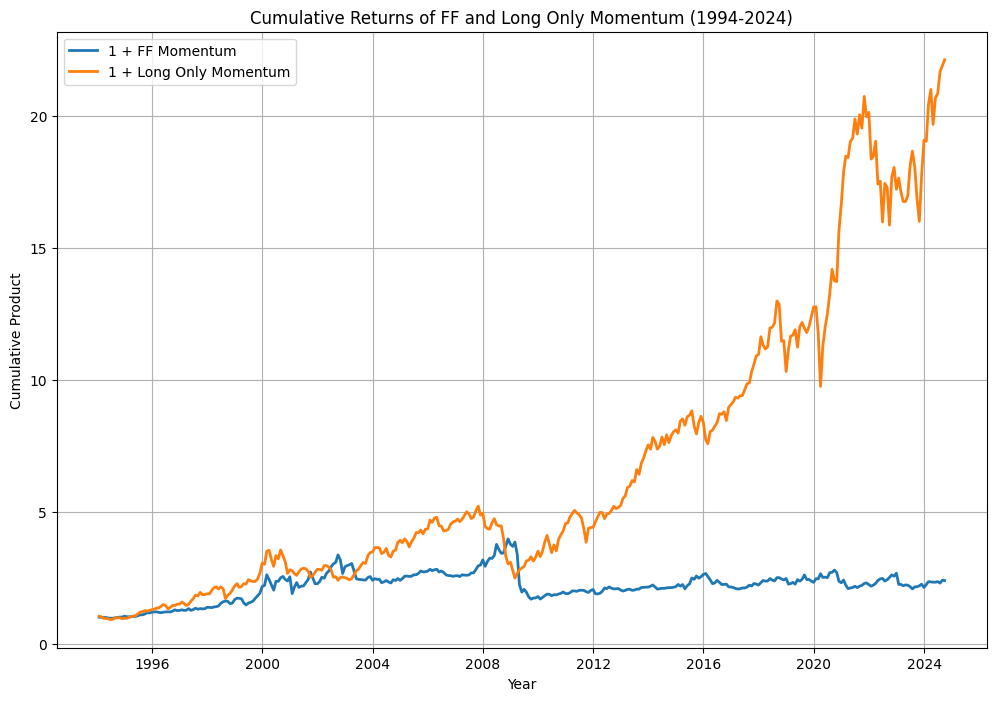

In [11]:
# plots

plot_1 = (ff_data.copy().loc[pd.to_datetime("1994-01-31"):pd.to_datetime("2024-09-30"),:] +1).cumprod()
plot_2 = (ff_long_only.to_frame('long_only_mom').copy().loc[pd.to_datetime("1994-01-31"):pd.to_datetime("2024-09-30"),:] + 1).cumprod()
plt.figure(figsize=(12, 8))
plt.plot(plot_1, label='1 + FF Momentum', linewidth=2)
plt.plot(plot_2, label='1 + Long Only Momentum', linewidth=2)
plt.title('Cumulative Returns of FF and Long Only Momentum (1994-2024)')
plt.xlabel('Year')
plt.ylabel('Cumulative Product')
plt.legend()
plt.grid(True)
plt.show()

### Q2.3 Is momentum just data mining or is it a robust strategy

In [12]:
decile_data = load_data("momentum_data.xlsx",sheet_name=3)
display(decile_data.head())

NA/Nulls present in data: 0


,Lo PRIOR,PRIOR 2,PRIOR 3,PRIOR 4,PRIOR 5,PRIOR 6,PRIOR 7,PRIOR 8,PRIOR 9,Hi PRIOR
Date,,,,,,,,,,
1927-01-31,-0.0332,-0.0446,0.0269,-0.0033,-0.0041,0.0097,0.0074,0.0036,-0.0041,-0.0024
1927-02-28,0.0753,0.0593,0.0825,0.0727,0.0322,0.0421,0.0283,0.0326,0.0420,0.0701
1927-03-31,-0.0323,-0.0301,-0.0392,-0.0477,-0.0048,-0.0242,0.0205,0.0041,0.0096,0.0547
1927-04-30,0.0204,-0.0320,-0.0247,-0.0137,0.0220,-0.0005,0.0205,-0.0059,0.0159,0.0549
1927-05-31,0.0272,0.0457,0.0595,0.0318,0.0636,0.0580,0.0496,0.0681,0.0811,0.0632


In [13]:
mom_d1 = decile_data["Hi PRIOR"] - decile_data["Lo PRIOR"]
mom_d3 = 1/3 * (decile_data.loc[:,"PRIOR 8":].sum(axis=1) - decile_data.loc[:,:"PRIOR 3"].sum(axis=1))
mom_d5 = 1/5 * (decile_data.loc[:,"PRIOR 6":].sum(axis=1) - decile_data.loc[:,:"PRIOR 5"].sum(axis=1))



def stats_calc(df):
    subsamples_dict = {
    "1927_2024":df.loc[pd.to_datetime("1927-01-31"):pd.to_datetime("2024-09-30"),:].copy(),
    "1927_1993":df.loc[pd.to_datetime("1927-01-31"):pd.to_datetime("1993-12-31"),:].copy(),
    "1994_2008":df.loc[pd.to_datetime("1994-01-31"):pd.to_datetime("2008-12-31"),:].copy(),
    "2009_2024":df.loc[pd.to_datetime("2009-01-31"):pd.to_datetime("2024-09-30"),:].copy(),
    "1994_2024":df.loc[pd.to_datetime("1994-01-31"):pd.to_datetime("2024-09-30"),:].copy(),
}

    long_mom_stats = list(map(lambda x: calculate_mom_performance(subsamples_dict[x],name=x),subsamples_dict.keys()))
    long_mom_stats = reduce(lambda x,y: pd.concat([x,y],axis=0),long_mom_stats)
    display(long_mom_stats)
    
print("MOM_D1" + "\n")
stats_calc(mom_d1.to_frame('mom_d1') if isinstance(mom_d1,pd.Series) else mom_d1)
print("MOM_D3" + "\n")
stats_calc(mom_d3.to_frame('mom_d3') if isinstance(mom_d3,pd.Series) else mom_d3)
print("MOM_D5" + "\n")
stats_calc(mom_d5.to_frame('mom_d5') if isinstance(mom_d5,pd.Series) else mom_d5)
    

MOM_D1



,Mean,Std,Sharpe,corr_to_market,corr_to_value,Annualized_mean,Annualized_std,skewness,Annualized_sharpe
1927_2024,0.011482,0.079091,0.145180,-0.369000,-0.404373,0.137789,0.273979,-2.221209,0.502920
1927_1993,0.013616,0.075501,0.180340,-0.396819,-0.493211,0.163390,0.261542,-2.812613,0.624717
1994_2008,0.013883,0.081592,0.170149,-0.240302,-0.052861,0.166593,0.282643,-0.854147,0.589413
2009_2024,0.000121,0.090306,0.001342,-0.377847,-0.393023,0.001454,0.312829,-1.601342,0.004648
1994_2024,0.006834,0.086324,0.079169,-0.319715,-0.233463,0.082010,0.299035,-1.304629,0.274248


MOM_D3



,Mean,Std,Sharpe,corr_to_market,corr_to_value,Annualized_mean,Annualized_std,skewness,Annualized_sharpe
1927_2024,0.006307,0.054855,0.114977,-0.381904,-0.396644,0.075686,0.190025,-2.511962,0.398293
1927_1993,0.008110,0.054345,0.149230,-0.393141,-0.481455,0.097318,0.188256,-3.101904,0.516948
1994_2008,0.007489,0.053330,0.140433,-0.288451,-0.021529,0.089871,0.184740,-0.894938,0.486473
2009_2024,-0.002487,0.057823,-0.043019,-0.414986,-0.383258,-0.029850,0.200305,-1.675280,-0.149022
1994_2024,0.002379,0.055825,0.042619,-0.361659,-0.211472,0.028551,0.193383,-1.345002,0.147638


MOM_D5



,Mean,Std,Sharpe,corr_to_market,corr_to_value,Annualized_mean,Annualized_std,skewness,Annualized_sharpe
1927_2024,0.004172,0.038549,0.108215,-0.361677,-0.391819,0.050059,0.133536,-2.495177,0.374869
1927_1993,0.005458,0.038444,0.141984,-0.369381,-0.472386,0.065501,0.133174,-3.014291,0.491848
1994_2008,0.004714,0.037221,0.126637,-0.277286,-0.016736,0.056563,0.128937,-1.140229,0.438684
2009_2024,-0.001819,0.039856,-0.045640,-0.401249,-0.389848,-0.021829,0.138067,-1.631718,-0.158101
1994_2024,0.001368,0.038679,0.035357,-0.348584,-0.212234,0.016411,0.133990,-1.415925,0.122480


b) The analysis of momentum strategy performance across 1-decile, 3-decile, and 5-decile constructions demonstrates alignment with theoretical expectations, highlighting the "selection effect." Data shows that **1-decile portfolios**, focusing on top performers, yield the highest mean returns and volatility, affirming the notion that narrow, high-performing selections enhance gains at increased risk levels. Conversely, **3-decile and 5-decile portfolios** exhibit decreased mean returns and volatility, supporting the theory that expanding asset selection reduces both the intensity of returns and associated risks. This trend is reflected in the **Sharpe Ratios**, which decline with broader asset selections, suggesting better risk-adjusted returns are achievable with more concentrated investments. All strategies show **negative correlations with market and value factors**, improving as more assets are included, which suggests enhanced diversification benefits. 




c) 1-Decile as we see similar correlations to market, but much better risk adjusted returns as compared to 5-decile construction. Annualised mean of only 2% for 5th decile might be very unattractive to retail customers who might just decide to invest in SPY for better risk adjusted rewards.

d) While there are similarities in performance characteristics, particularly in terms of negative correlations with the market and value, the general long-short momentum strategy and the 3-decile segmented strategy for small and large stocks are not the same in terms of performance. The general long-short strategy offers higher mean returns and more efficient risk-adjusted returns as indicated by a higher Sharpe Ratio. The differences in performance can be attributed to the impact of segmenting the stocks by size (Farma and French), which introduces a different risk and return profile, likely due to the varying dynamics and behaviors of small versus large stocks in the market. Segmenting by size ensures that the momentum factor does not merely replicate the size or value effects already accounted for in the model. It helps isolate the pure effect of momentum from other influencing factors like size or book-to-market ratios, thereby enhancing the robustness of the model. By combining and averaging the returns of the top momentum stocks in both small and big categories and subtracting the averaged returns of the bottom momentum stocks, Fama and French aim to neutralize broader market movements that might affect the momentum premium observed.

### Q2.4 Does implementing momentum require trading lots of small stocks—thus causing even larger trading costs

In [14]:
small_stock_data = (ff_raw_data["SMALL HiPRIOR"]-ff_raw_data["SMALL LoPRIOR"]).to_frame("small_stock_data")
big_stock_data = (ff_raw_data["BIG HiPRIOR"]-ff_raw_data["BIG LoPRIOR"]).to_frame("big_stock_data")
all_stocks = ff_data.copy()

subsamples_dict = {
    "All stocks":all_stocks.loc[pd.to_datetime("1994-01-01"):pd.to_datetime("2024-09-30"),:].copy(),
    "Small Stocks":small_stock_data.loc[pd.to_datetime("1994-01-01"):pd.to_datetime("2024-09-30"),:].copy(),
    "Large stocks":big_stock_data.loc[pd.to_datetime("1994-01-01"):pd.to_datetime("2024-09-30"),:].copy(),

}
mom_stats = list(map(lambda x: calculate_mom_performance(subsamples_dict[x],name=x),subsamples_dict.keys()))
mom_stats = reduce(lambda x,y: pd.concat([x,y],axis=0),mom_stats)
print("Table 4: Momentum of small and big stocks")
display(mom_stats)


Table 4: Momentum of small and big stocks


,Mean,Std,Sharpe,corr_to_market,corr_to_value,Annualized_mean,Annualized_std,skewness,Annualized_sharpe
All stocks,0.003599,0.048406,0.074344,-0.306180,-0.215225,0.043184,0.167682,-1.445951,0.257534
Small Stocks,0.005267,0.048969,0.107551,-0.303976,-0.148512,0.063200,0.169633,-1.763649,0.372569
Large stocks,0.001931,0.052671,0.036670,-0.280159,-0.257523,0.023177,0.182458,-0.879114,0.127028


Small stocks momentunm strategy does offer better risk adjusted rewards as seen from the large sharpe and mean, and lower volatility. However, large stocks still offer positive sharpe and positive excess returns.

AQR's momentum strategy is capturing most of the features of th FF, maintaining relatively low correlation to the market through hedging, albeit at a smaller risk adjusted returns from the focusing on large stocks. AQR could consider using 1-decile instead of 3 for higher mean and sharpe ratio.

# Question 4: Barnstable's Analysis

In [15]:
### Q4.1
from itables import show
def load_data(filename, data_dir="data",sheet_name: Union[str, int] = 0) -> pd.DataFrame:
    file_path = os.path.join(data_dir, filename)
    data = pd.read_excel(file_path, sheet_name=sheet_name,parse_dates=True)
    data.set_index("date", inplace=True) if "date" in data.columns else data
    data.set_index("Date", inplace=True) if "Date" in data.columns else data
    print(f"NA/Nulls present in data: {data.isnull().sum().sum()}")
    return data
barn_data = load_data("barnstable_analysis_data.xlsx",sheet_name=1)

barn_data = barn_data.assign(spx_excess_returns = barn_data["SPX"] - barn_data["TB1M"])
show(barn_data)

NA/Nulls present in data: 12


In [16]:
barn_subdata = {"1965_1999":barn_data.loc[pd.to_datetime("1965-01-01"):pd.to_datetime("1999-12-31"),:],
                "2000-2024":barn_data.loc[pd.to_datetime("2000-01-01"):pd.to_datetime("2024-12-31"),:],
                "1926-2024":barn_data.loc[pd.to_datetime("1926-01-01"):pd.to_datetime("2024-12-31"),:]}

def calc_barn_stats(df,name=""):
    stat_df = pd.DataFrame()
    stat_df =stat_df.assign(Mean = df.mean(), 
                   Std = df.std(), 
                   Sharpe = df.mean()/df.std(),
                   Annualized_mean = df.mean()*12,
                   Annualized_std = df.std()*np.sqrt(12),
                   skewness = df.skew(),
                   Annualized_sharpe = df.mean()*np.sqrt(12)/df.std()).T
    index = pd.MultiIndex.from_tuples(list(zip(np.repeat(name,len(stat_df.columns)),stat_df.columns)))
    stat_df.columns = index
    return stat_df

barn_stats = list(map(lambda x: calc_barn_stats(barn_subdata[x],name = x),barn_subdata.keys()))
reduced_df = pd.merge(barn_stats[0],barn_stats[1],left_index=True,right_index=True).merge(barn_stats[2],left_index=True,right_index=True)

print("Barnstable analysis")
display(reduced_df)


Barnstable analysis


1965_1999                              2000-2024            \
                        SPX      TB1M spx_excess_returns       SPX      TB1M   
Mean               0.010780  0.005125           0.005722  0.007274  0.001433   
Std                0.043130  0.002072           0.043367  0.044183  0.001597   
Sharpe             0.249934  2.473099           0.131936  0.164624  0.897373   
Annualized_mean    0.129354  0.061503           0.068660  0.087283  0.017200   
Annualized_std     0.149405  0.007179           0.150227  0.153055  0.005533   
skewness          -0.349411  1.419082          -0.365017 -0.483852  0.882392   
Annualized_sharpe  0.865795  8.567067           0.457040  0.570273  3.108591   

                                     1926-2024                               
                  spx_excess_returns       SPX      TB1M spx_excess_returns  
Mean                        0.005840  0.009628  0.002658           0.006945  
Std                         0.044265  0.053918  0.002458           0.054115  
Sharpe                      0.131940  0.178566  1.081361           0.128339  
Annualized_mean             0.070083  0.115535  0.031902           0.083340  
Annualized_std              0.153337  0.186777  0.008516           0.187459  
skewness                   -0.471701  0.320120  1.099154           0.362694  
Annualized_sharpe           0.457052  0.618571  3.745944           0.444578

In [17]:
log_barnstable_data = barn_data.copy()


log_barnstable_data = log_barnstable_data.assign(log_SPX = np.log(1+barn_data["SPX"]),
                                                    log_TB1M = np.log(1+barn_data["TB1M"]),
                                                    log_spx_excess_returns = np.log(1+barn_data["spx_excess_returns"])).drop(columns=["SPX","TB1M","spx_excess_returns"])
log_barn_subdata = {"1965_1999":log_barnstable_data.loc[pd.to_datetime("1965-01-01"):pd.to_datetime("1999-12-31"),:],
                "2000-2024":log_barnstable_data.loc[pd.to_datetime("2000-01-01"):pd.to_datetime("2024-12-31"),:],
                "1926-2024":log_barnstable_data.loc[pd.to_datetime("1926-01-01"):pd.to_datetime("2024-12-31"),:]}
log_stats = list(map(lambda x: calc_barn_stats(log_barn_subdata[x],name = x),log_barn_subdata.keys()))
reduced_df = pd.merge(log_stats[0],log_stats[1],left_index=True,right_index=True).merge(log_stats[2],left_index=True,right_index=True)
display(reduced_df)

1965_1999                                  2000-2024  \
                    log_SPX  log_TB1M log_spx_excess_returns   log_SPX   
Mean               0.009800  0.005110               0.004763  0.006271   
Std                0.043177  0.002059               0.043650  0.044465   
Sharpe             0.226974  2.481992               0.109129  0.141041   
Annualized_mean    0.117600  0.061320               0.057161  0.075257   
Annualized_std     0.149568  0.007132               0.151207  0.154032   
skewness          -0.638532  1.412176              -0.647775 -0.655694   
Annualized_sharpe  0.786262  8.597873               0.378033  0.488579   

                                                   1926-2024            \
                   log_TB1M log_spx_excess_returns   log_SPX  log_TB1M   
Mean               0.001431               0.004841  0.008150  0.002652   
Std                0.001594               0.044600  0.053713  0.002449   
Sharpe             0.897847               0.108550  0.151737  1.083020   
Annualized_mean    0.017173               0.058096  0.097804  0.031823   
Annualized_std     0.005521               0.154498  0.186068  0.008482   
skewness           0.880999              -0.642138 -0.482537  1.091105   
Annualized_sharpe  3.110234               0.376028  0.525633  3.751691   

                                          
                  log_spx_excess_returns  
Mean                            0.005473  
Std                             0.053996  
Sharpe                          0.101367  
Annualized_mean                 0.065680  
Annualized_std                  0.187046  
skewness                       -0.441955  
Annualized_sharpe               0.351145

the full-sample stats typically show more volatility and less favorable risk-adjusted returns compared to the sub-samples, indicating the effect of including more diverse market conditions over a longer period. Comparing level and log stats, log transformations generally provide more conservative estimates, with lower mean returns and slightly higher volatility, affecting the calculated financial metrics like Sharpe Ratios. 

### Question 4.2: Recall the following...

In [18]:
barn_subsample = log_barnstable_data.loc[pd.to_datetime("1965-01-01"):pd.to_datetime("1999-12-31"),:]

In [19]:
barn_subsample_cumulative = (barn_subsample).cumsum()
show(barn_subsample_cumulative)

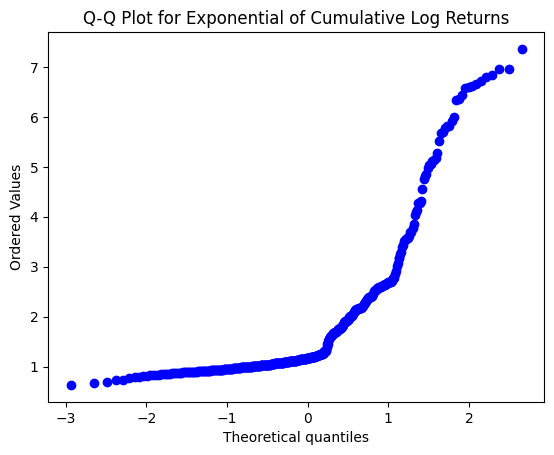

In [20]:
from scipy.stats import probplot
exponential_of_cumulative_log_returns = np.exp(barn_subsample_cumulative)
fig, ax = plt.subplots()
probplot(exponential_of_cumulative_log_returns["log_spx_excess_returns"], dist="norm", plot=ax)
ax.set_title('Q-Q Plot for Exponential of Cumulative Log Returns')
plt.show()


In [21]:
from scipy.stats import norm
# Probability distribution of cumulative log market returns for 1965-1999
mean_1965_1999 = barn_subsample_cumulative["log_spx_excess_returns"].mean()
std_1965_1999 = barn_subsample_cumulative["log_spx_excess_returns"].std()
barn_subsample_cumulative["z_score"] = (barn_subsample_cumulative["log_TB1M"] - mean_1965_1999) / std_1965_1999
end_date = barn_subsample_cumulative.iloc[-1]
end_date_z_score = end_date["z_score"]
prob = norm.cdf(end_date_z_score)
print(f"Prob for subsample 1965-1999: {prob}")


Prob for subsample 1965-1999: 0.998721491377811


In [22]:
# Precise prob for h =15 and h=30
start_date = barn_subsample_cumulative.index.min()  
end_date_15 = start_date + pd.DateOffset(years=15)
end_date_30 = start_date + pd.DateOffset(years=30)
data_at_15_years = barn_subsample_cumulative.asof(end_date_15)
data_at_30_years = barn_subsample_cumulative.asof(end_date_30)
end_date_z_score_15 = data_at_15_years["z_score"]
end_date_z_score_30 = data_at_30_years["z_score"]
prob_15 = norm.cdf(end_date_z_score_15)
prob_30 = norm.cdf(end_date_z_score_30)
display(data_at_15_years)
print(f"Prob at h equals 15 years: {prob_15}")
display(data_at_30_years)
print(f"Prob at h equals 30 years: {prob_30}")


log_SPX                   0.808401
log_TB1M                  0.840354
log_spx_excess_returns   -0.017451
z_score                   0.726854
Name: 1980-01-29 00:00:00, dtype: float64

Prob at h equals 15 years: 0.7663423603569468


log_SPX                   2.847181
log_TB1M                  1.897755
log_spx_excess_returns    0.966489
z_score                   2.588156
Name: 1995-01-29 00:00:00, dtype: float64

Prob at h equals 30 years: 0.995175430829573


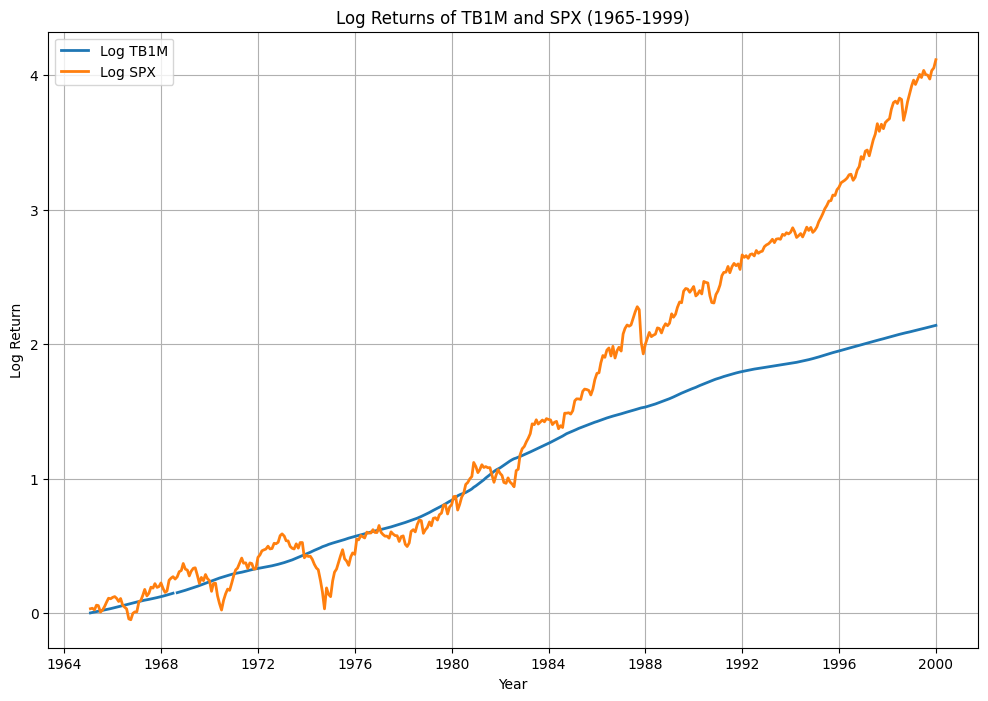

In [23]:
# plot log returns for T bill and SPX
plt.figure(figsize=(12, 8))
plt.plot(barn_subsample_cumulative["log_TB1M"], label='Log TB1M', linewidth=2)
plt.plot(barn_subsample_cumulative["log_SPX"], label='Log SPX', linewidth=2)
plt.title('Log Returns of TB1M and SPX (1965-1999)')
plt.xlabel('Year')
plt.ylabel('Log Return')
plt.legend()
plt.grid(True)
plt.show()

Text(0.5, 0, 'Year')

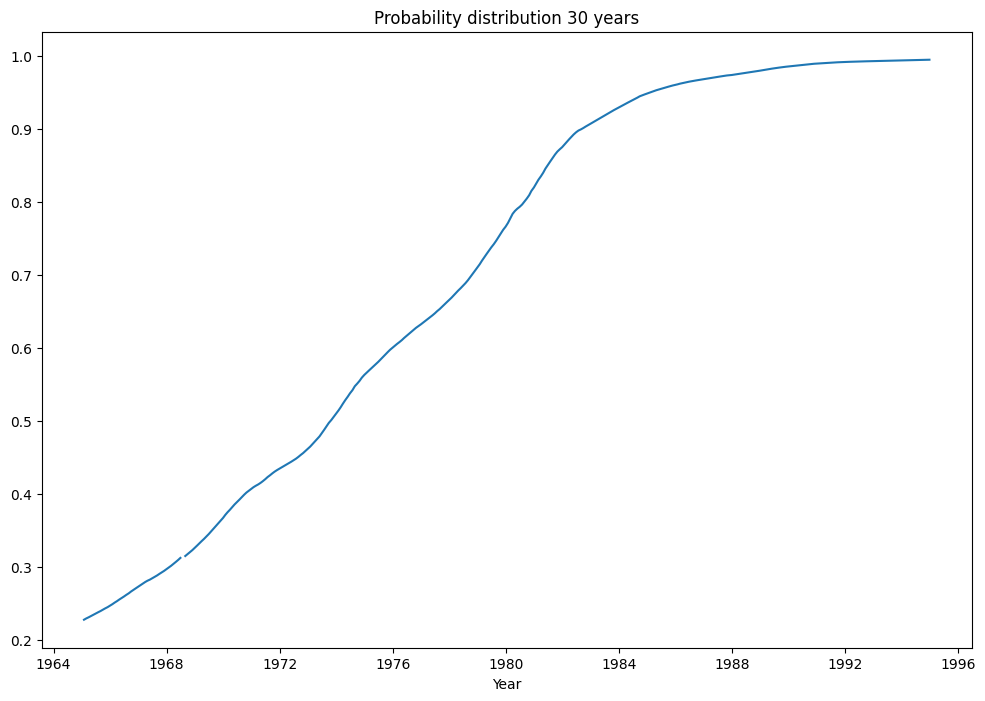

In [24]:
horizon = barn_subsample_cumulative.loc[:data_at_30_years.name]
probabilities = pd.DataFrame(index=horizon.index)
probabilities["Probabilities"] = norm.cdf(horizon["z_score"])
plt.figure(figsize=(12, 8))
plt.line = plt.plot(probabilities, label='Probability distribution')
plt.title('Probability distribution 30 years')
plt.xlabel('Year')

### Question 3.3: 

In [25]:
barn_subsample_cumulative_2024 = (barn_subsample).loc[pd.to_datetime("1965-01-30"):pd.to_datetime("2024-12-31")].cumsum()
mean_1965_2024 = barn_subsample_cumulative_2024["log_spx_excess_returns"].mean()
std_1965_2024 = barn_subsample_cumulative_2024["log_spx_excess_returns"].std()
barn_subsample_cumulative_2024["z-score"] = (barn_subsample_cumulative_2024["log_TB1M"] - mean_1965_2024) / std_1965_2024
barn_subsample_cumulative_2024["prob"] = norm.cdf(barn_subsample_cumulative_2024["z-score"])
end_date_15 = barn_subsample_cumulative_2024.asof(barn_subsample_cumulative_2024.index.min() + pd.DateOffset(years=15))
end_date_30 = barn_subsample_cumulative_2024.asof(barn_subsample_cumulative_2024.index.min() + pd.DateOffset(years=30))
print(f"Prob at h equals 15 years: {end_date_15['prob']}")
print(f"Prob at h equals 30 years: {end_date_30['prob']}")


Prob at h equals 15 years: 0.7854716465045468
Prob at h equals 30 years: 0.9958723563826395


### Question 3.4: 

In [26]:
mean_1965_1999 = barn_subsample_cumulative["log_SPX"].mean()
std_1965_1999 = barn_subsample_cumulative["log_SPX"].std()
data_1999 = barn_subsample_cumulative.iloc[-1]
expected_2024 = mean_1965_1999 * 25 + data_1999["log_SPX"]
print(expected_2024)
realized_2024 = barn_subsample_cumulative_2024["log_SPX"].iloc[-1]
print(realized_2024)
prob_2024 = norm.cdf((expected_2024 - realized_2024) / std_1965_1999)
print(f"Prob for 2024: {prob_2024}")


41.562289565486566
4.081801165491205
Prob for 2024: 1.0
